# CS492: 전산학특강<스마트에너지를 위한 인공지능> 
## Deep Learning Practice 
#### Prof. Ho-Jin Choi
#### School of Computing, KAIST

---

## Day 2 - MLP-based Classification
### 2-1. Image classification using MNIST dataset

Now, let's build our first fully connected feed-forward network! We'll build a neural network consisting of two fully connected layers and apply this to the digit classification task. Our network will ultimately output **a probability distribution over the 10 digit classes (0-9)**. The architecture of the network we are going to build is depicted below:

![Architecture - MNIST](images/architecture-mnist.png)

#### MNIST dataset

The [MNIST dataset](http://yann.lecun.com/exdb/mnist) is a large database of handwritten digits that is commonly used for training various image processing systems. This dataset consists of 60,000 training images and 10,000 test images. The target classes for this dataset are the digits (0-9). 

Let's download and load the dataset and display a few random samples from it:

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
print('Tensorflow: ', tf.__version__)

import numpy as np
import matplotlib.pyplot as plt

Tensorflow:  2.0.0


In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape)

train_images = np.expand_dims(train_images, axis=-1) / 255
print(train_images.shape)

train_labels = np.int64(train_labels)
test_images = np.expand_dims(test_images, axis=-1) / 255
test_labels = np.int64(test_labels)
class_names = ['0','1','2','3','4','5','6','7','8','9']

(60000, 28, 28)
(60000, 28, 28, 1)


Our training set is made up of 28x28 grayscale images of handwritten digits. Let's visualize what some of these images and their corresponding training labels look like.

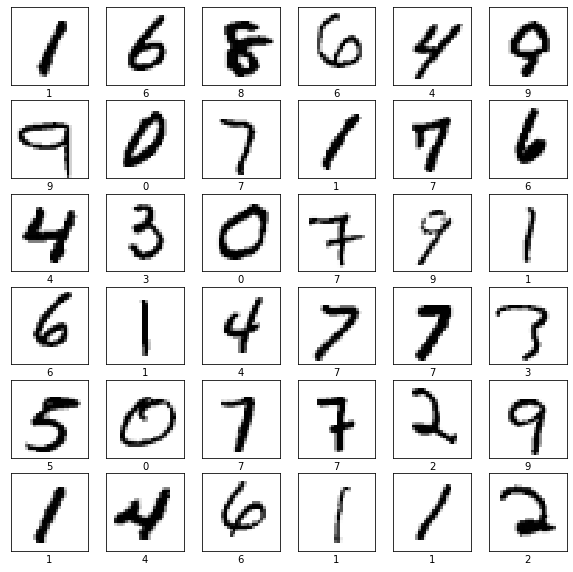

In [3]:
plt.figure(figsize=(10, 10))
random_indicies = np.random.choice(60000, 36)

for index in range(36):
    plt.subplot(6, 6, index + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_index = random_indicies[index]
    plt.imshow(np.squeeze(train_images[image_index]), cmap=plt.cm.binary)
    plt.xlabel(train_labels[image_index])

#### Build model

To define the architecture of the fully connected neural network, we'll once again use the Keras API and define the model using the [`tf.keras.Sequential`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Sequential) class. Note that how we first use a [`tf.keras.layers.Flattern`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Flatten) layer, which flattens the input so that it can be fed into the model. 

In [4]:
# TODO: define a sequential model
model = tf.keras.Sequential([
    # TODO: add a flatten layer
    tf.keras.layers.Flatten(input_shape=train_images.shape[1:]),
    # TODO: add the first dense layer with 128 nodes applying ReLU activation function
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    # TODO: add the last dense layer with 10 (the number of digits) nodes applying Softmax activation function
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


![Flatten](images/flatten.png)

Let's take a step back and think about the network we've just created. The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a 2d-array (28 x 28 pixels), to a 1d-array of 28 * 28 = 784 pixels. You can think of this layer as unstacking rows of pixels in the image and lining them up. There are no learned parameters in this layer; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are fully connected neural network layers. 
- The first `Dense` layer has 128 nodes (or neurons)
    - ReLU $ f(x) = \max(0, x) $ activation function is applied to an output of this layer.
        - This introduces **non-linearity** in the input space.
        - The non-linearity is where the network learns to capture complicated relationships.
- The last `Dense` layer has 10 nodes (or neurons)
    - Softmax $ f_j(z) = \frac{e^{z_j}}{\sum_{K} e^{z_k}} $ activation function is applied to an output of this layer.
        - This takes a vector of arbitrary real-valued scores and squashes it to **a vector of values between zero and one that sum to one**.
        - That vector can represent a probability distribution over predicted output classes given the input value.

#### Compile the model

Before training the model, we need to define a few more settings. These are added during the model's [`compile`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model) step:

- *Loss function*: This defines how we measure how accurate the model is. During training, we want to minimize this function, which will "steer" the model in the right direction.
- *Optimizer*: This defines how the model is updated based on the data it sees and its loss function.
- *Metrics*: Here we can define metrics used to monitor the training and testing steps.

We'll start out by using a stochastic gradient descent (SGD) optimizer initialized with a learning rate of 0.1. Since we are performing a categorical classification task, we will use the [(sparse) cross entropy loss](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy).

You might want to experiment with both the choice of optimizer and learning rate and evaluate how these affect the accuracy of the trained model. 

In [5]:
# TODO: compile the model with the following parameters
# - Optimizer: adam optimizer
# - Loss: sparse_categorical_crossentropy 
# - Metrics: accuracy
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### Train the model

We're now ready to train our model, which will involve feeding the training data `(train_images, train_labels)` into the model, and then asking it to learn the associations between images and labels. We'll also need to define the batch size and the number of epochs, or iterations over the MNIST dataset, to use during training. With the Keras API and defining the model settings in the `compile` step, training is all accomplished by calling the [`fit`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#fit) method on an instance of the `Model` class. 


In [6]:
# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 64
EPOCHS = 10

In [7]:
# TODO: train the model using (train_images, train_labels). 
#       do not forget to set epochs and batch size as the parameters!
network_history = model.fit(train_images, 
                            train_labels, 
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 41us/sample - loss: 0.2965 - accuracy: 0.9166
Epoch 2/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.1391 - accuracy: 0.9594
Epoch 3/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0975 - accuracy: 0.9717
Epoch 4/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0746 - accuracy: 0.9782
Epoch 5/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0598 - accuracy: 0.9823
Epoch 6/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0481 - accuracy: 0.9857
Epoch 7/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0391 - accuracy: 0.9888
Epoch 8/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0322 - accuracy: 0.9901
Epoch 9/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0260 - accuracy: 0.9927
Epoch 10/10
60

As the model trains, the loss and accuracy metrics are displayed. With five epochs and a learning rate of 0.01, this fully connected model should achieve an accuracy of approximatley 0.97 (or 97%) on the training data.

#### Plotting network performance trend

The return value of the `fit` function is a `tf.keras.callbacks.History` object which contains the entire history of training/validation loss and accuracy, for each epoch. We can therefore plot the behaviour of loss and accuracy during the training phase.

In [8]:
history_dict = network_history.history
history_dict.keys()

dict_keys(['loss', 'accuracy'])

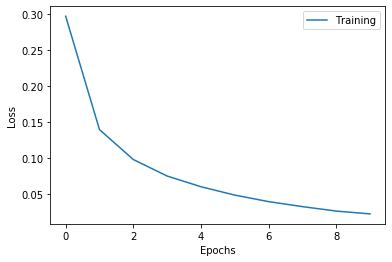

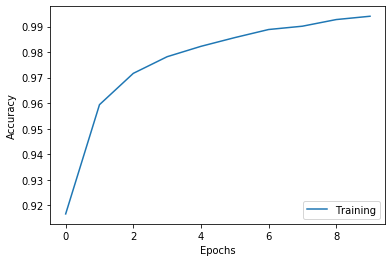

In [9]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.legend(['Training'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

#### Evaluate accuracy on the test dataset

Now that we've trained the model, we can ask it to make predictions about a test set that it hasn't seen before. In this example, the `test_images` array comprises our test dataset. To evaluate accuracy, we can check to see if the model's predictions match the labels from the `test_labels` array. 

Use the [`evaluate`](https://tensorflow.google.cn/api_docs/python/tf/keras/models/Sequential#evaluate) method to evaluate the model on the test dataset!

In [13]:
# TODO: evaluate the model using (test_images, test_labels)
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
print('Test accuracy:', test_accuracy)

10000/1 - 0s - loss: 0.0392 - accuracy: 0.9780
Test accuracy: 0.978


In [14]:
# TODO: evaluate the model using (test_images, test_labels)
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
print('Test accuracy:', test_accuracy)

Test accuracy: 0.978


You may observe that the accuracy on the test dataset is a little lower than the accuracy on the training dataset. This gap between training accuracy and test accuracy is an example of *overfitting*, when a machine learning model performs worse on new data than on its training data. 

#### Make predictions
With the model trained, you can use it to make predictions about some images.

In [15]:
predictions = model.predict(test_images)

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

[8.0207085e-09 1.0217122e-09 2.0368971e-06 2.3305776e-04 6.4087720e-12
 3.3264783e-07 1.4797279e-13 9.9975604e-01 6.0870225e-06 2.4184853e-06]


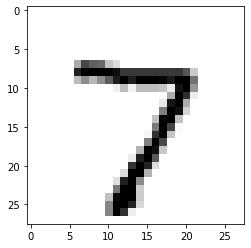

In [16]:
print(predictions[0])
plt.imshow(np.squeeze(test_images[0]), cmap=plt.cm.binary)

With this function call, the model has predicted the label for each image in the testing set. Let's take a look at the prediction for the first image in the test dataset:

In [17]:
print('Predicted digit for test image[0]: {}'.format(np.argmax(predictions[0])))

Predicted digit for test image[0]: 7


So, the model is most confident that this image is a "7". We can check the test label (remember, this is the true identity of the digit) to see if this prediction is correct:

In [18]:
print('Ground truth of test image[0]: {}'.format(test_labels[0]))

Ground truth of test image[0]: 7


We can define a couple of functions to help visualize the classification results on the MNIST dataset. First, we'll write a function, `plot_image`, to plot images along with their predicted label and the probability of the prediction. Second, we'll also define a function, `plot_value_array`, to plot the prediction probabilities for each of the digits. 

In [19]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(np.squeeze(img), cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

Let's use these functions to visualize the model's predictions for the images in the test dataset: 

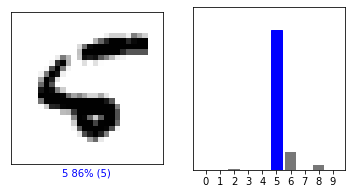

In [20]:
i = 8 
plt.figure(figsize=(6,3))
plt.subplot(1, 2, 1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions[i], test_labels)
plt.show()

We can also plot several images along with their predictions, where correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent confidence (out of 100) for the predicted label. Note the model can be very confident in an incorrect prediction!

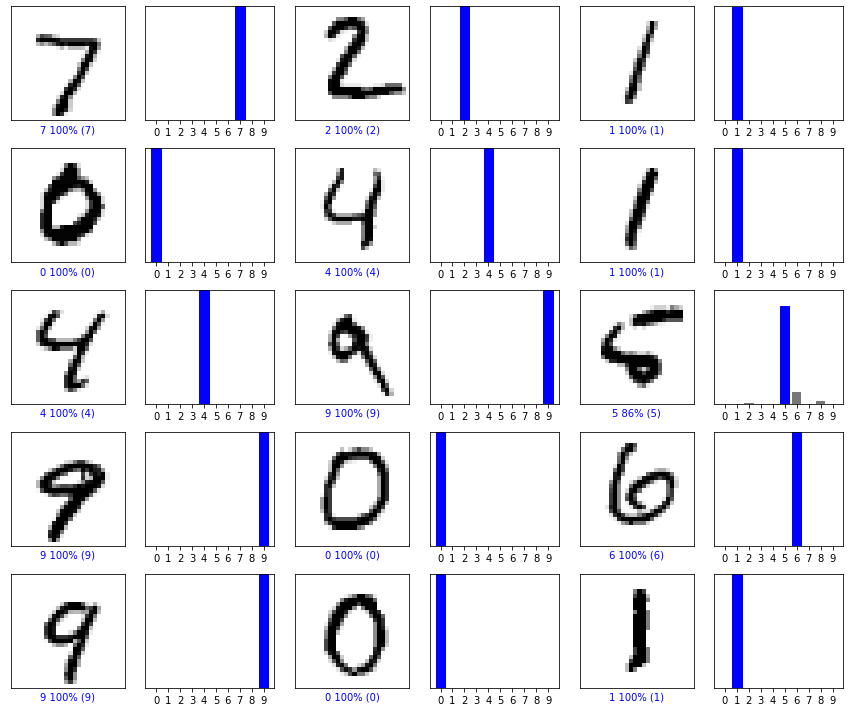

In [21]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()